# Create a Model with TensorFlow (WIP)
This notebook contains the steps needed to build a CNN image classifier.
 

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import os

2024-02-02 15:49:05.592444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# fyi add ?? to see documentation 
tf.keras??

### Check for images:

In [2]:
# set the path to images
dataset_dir = './image_scrape_code/screenshots'

# append dir and folder name into a list 
image_files = [
    os.path.join(dataset_dir, filename)
    for filename in os.listdir(dataset_dir)
    if filename.endswith(".png")
]
print(len(image_files))

97


### Resize if needed (Don't run yet):

In [ ]:
# resize
size = 224, 224

# create the dir if it doesn't exist
processed_dir = 'processed_images'
os.makedirs(processed_dir, exist_ok=True)

for i in image_files:
    try:
        im = Image.open(i)
        im.thumbnail(size, Image.Resampling.LANCZOS)
        
        # filename without the path
        filename = os.path.basename(i)
        
        # create new path for the processed image
        processed_path = os.path.join(processed_dir, filename)
        
        # save 
        im.save(processed_path, "PNG")
        
        print(f"Processed {i} saved as {processed_path}")
        
    except IOError:
        print(f"Error rescale for {i}")
        

### Add Lables:

In [3]:
# labels based on file names 
labels = [1 if "person" in filename else 0 for filename in image_files]



## Load Data:

In [ ]:
#skip currently not working
data = tf.keras.utils.image_dataset_from_directory??

In [4]:
# load and preprocess the images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # resize to desired dimensions
    image = tf.cast(image, tf.float32) / 255.0  # Scale (normalize pixel values between 0 and 1)
    return image, label


In [5]:
# create a TensorFlow dataset from the image files and labels
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
print(len(dataset))

# map the preprocessing function to the dataset
dataset = dataset.map(load_and_preprocess_image)
print(len(dataset))

# shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(image_files),reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=16) #try: 16 ,32, 64
print(len(dataset))
data_itr = dataset.as_numpy_iterator()
batch = data_itr.next()


print(len(batch)) #should have two
print(batch[0].shape) 
print(f'Min: {batch[0].min()} Max: {batch[0].max()}')


97
97
7
2
(16, 256, 256, 3)
Min: 0.0 Max: 1.0


### Check Lables:

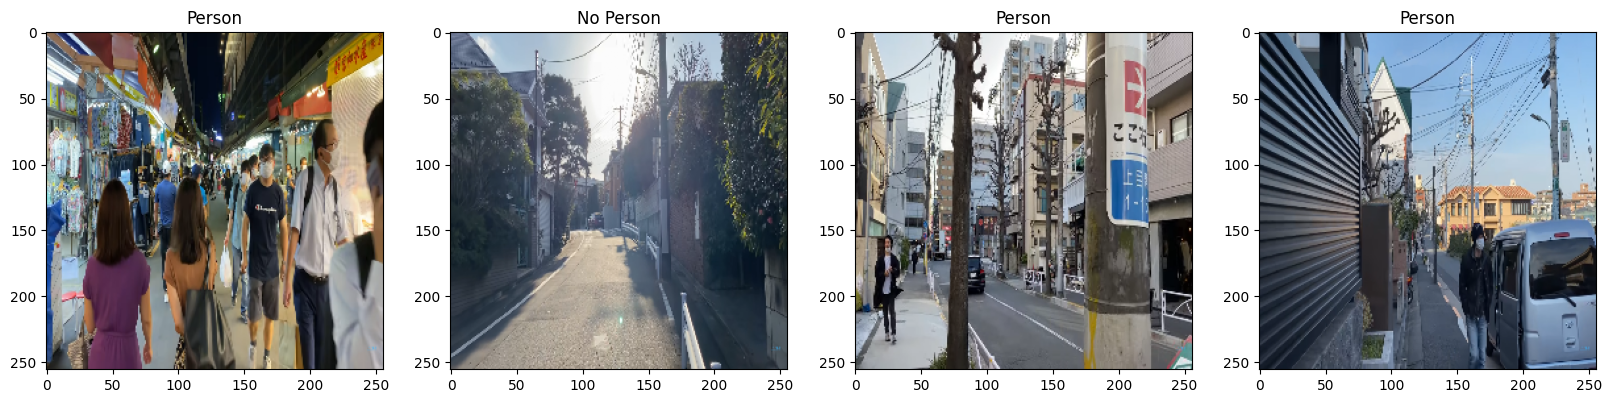

In [6]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, (img, label) in enumerate(zip(batch[0][:4], batch[1][:4])):
    ax[idx].imshow(img)
    title = "Person" if label == 1 else "No Person"
    ax[idx].title.set_text(title)
plt.show()


In [7]:
dataset.as_numpy_iterator().next()

(array([[[[0.19387256, 0.19031863, 0.19387256],
          [0.17463236, 0.17463236, 0.17463236],
          [0.15134804, 0.15134804, 0.15134804],
          ...,
          [0.654902  , 0.6431373 , 0.68235296],
          [0.63529414, 0.62352943, 0.6627451 ],
          [0.6466912 , 0.6345588 , 0.6702206 ]],
 
         [[0.38296568, 0.37340686, 0.3762255 ],
          [0.30637255, 0.29852942, 0.30134803],
          [0.24534313, 0.24534313, 0.24534313],
          ...,
          [0.63982844, 0.6252451 , 0.6644608 ],
          [0.65208334, 0.64031863, 0.6795343 ],
          [0.6386029 , 0.6268382 , 0.66495097]],
 
         [[0.24448529, 0.23480392, 0.23664215],
          [0.2528186 , 0.24105392, 0.24497549],
          [0.24656862, 0.24056372, 0.24056372],
          ...,
          [0.64865196, 0.63480395, 0.67401963],
          [0.6313726 , 0.61960787, 0.65882355],
          [0.64705884, 0.63529414, 0.67058825]],
 
         ...,
 
         [[0.5375    , 0.63553923, 0.72181374],
          [0.55110

In [8]:
len(dataset)

7

### Split data into training, validation and test:

In [9]:
train_size = int(len(dataset)* .7)
val_size = int(len(dataset)*.2) + 1
test_size = int(len(dataset)*.1) + 1

In [10]:
print(f'train: {train_size}, Val: {val_size},test:  {test_size}')

train: 4, Val: 2,test:  1


In [11]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

### Build Model:

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten



In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu' ))
model.add(Dense(1,activation='sigmoid' ))

In [15]:
#tf.optimizers??
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Note: 
The first param of model.compile is the optimizer (in this case ['adam'](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)).

The optimizer updates the model in response to the output of the loss function.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [17]:
logdir='logs'

In [18]:
#for logging how the model training performs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
4/4 [==============================] - 3s 527ms/step - loss: 0.9955 - accuracy: 0.5156 - val_loss: 0.6626 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 555ms/step - loss: 0.6566 - accuracy: 0.5938 - val_loss: 0.7367 - val_accuracy: 0.3750
Epoch 3/10
4/4 [==============================] - 2s 566ms/step - loss: 0.6738 - accuracy: 0.5625 - val_loss: 0.6508 - val_accuracy: 0.8438
Epoch 4/10
4/4 [==============================] - 2s 507ms/step - loss: 0.6324 - accuracy: 0.5938 - val_loss: 0.6227 - val_accuracy: 0.6250
Epoch 5/10
4/4 [==============================] - 2s 475ms/step - loss: 0.5791 - accuracy: 0.8125 - val_loss: 0.5551 - val_accuracy: 0.6562
Epoch 6/10
4/4 [==============================] - 2s 476ms/step - loss: 0.5250 - accuracy: 0.7344 - val_loss: 0.4003 - val_accuracy: 0.8750
Epoch 7/10
4/4 [==============================] - 2s 478ms/step - loss: 0.4248 - accuracy: 0.8594 - val_loss: 0.3307 - val_accuracy: 0.9688
Epoch 8/10
4/4 [====

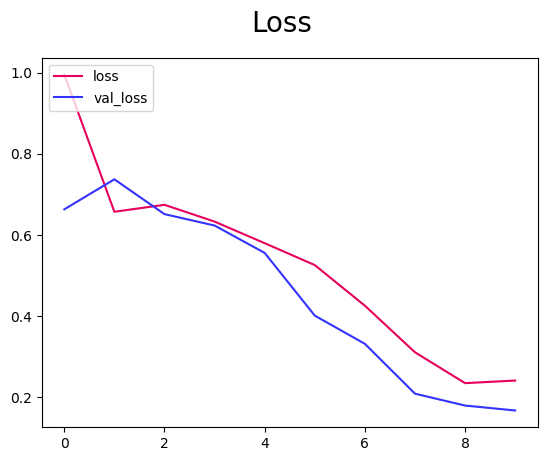

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='#e6005c', label='loss')
plt.plot(hist.history['val_loss'], color='#3333ff', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


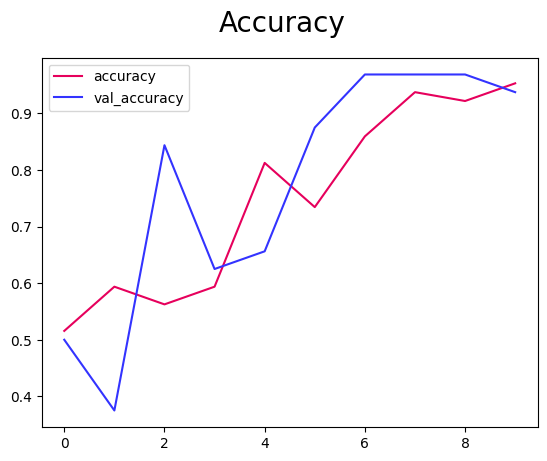

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='#e6005c', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='#3333ff', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test Model:

In [22]:
import cv2

In [23]:
# set the path to your dataset
test_dir = './image_scrape_code/test_images'

# append dir and folder name into a list 
test_image_files = [
    os.path.join(test_dir, filename)
    for filename in os.listdir(test_dir)
    if filename.endswith(".png")
]
print(len(test_image_files))

4


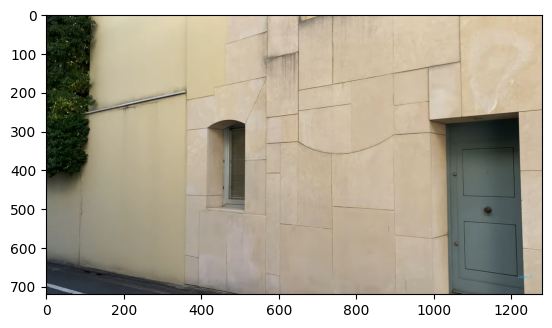

In [40]:
image = test_image_files[3]
img = cv2.imread(image)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

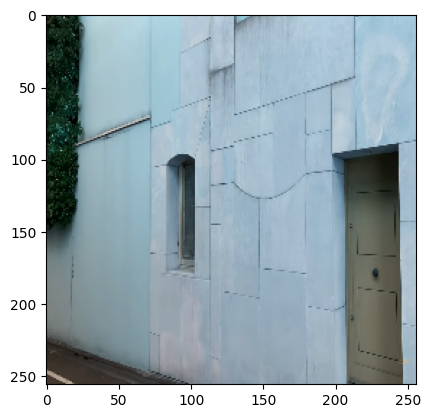

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
#the no.expand puts into another array. Our model expects a batch not a sinlge image
prediction = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 29ms/step


In [43]:
prediction

array([[0.13353631]], dtype=float32)

In [44]:
if prediction > 0.5:
    print(f'{image} has a person in it')
else:
     print(f'{image} has no person in it')

./image_scrape_code/test_images/test-screenshot-2024-01-29T00-46-02.043Z.png has no person in it


### Evaluate:

In [45]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [46]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [47]:
for batch in test.as_numpy_iterator():
    x,y = batch
    prediction = model.predict(x)
    precision.update_state(y,prediction)
    recall.update_state(y,prediction)
    accuracy.update_state(y,prediction)

1/1 [==============================] - 0s 28ms/step


### A higher number (0-1) is better:

In [48]:
print(f'Precision: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()} ')

Precision: 0.0, Recall: 0.0, Accuracy: 1.0 


### Save Model:

In [49]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models', 'person_in_img_classifier.h5'))
new_model = load_model('person_in_img_classifier.h5')
new_model.predict(np.expand_dims(resize/255,0))

OSError: No file or directory found at person_in_img_classifier.h5